# NLP project: Extracting skills from job descriptions.
# MLM

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk import ngrams
import sentencepiece as spm

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertForMaskedLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import Dataset
import torch
from torch.backends import cuda

import os
from tqdm import tqdm
from GPUtil import showUtilization
from transformers import logging
from transformers import AutoModelForMaskedLM
from transformers import TrainerCallback

На предыдущем этапе мы предобработали данные для обучения

In [7]:
df_description = pd.read_excel ('df_description_2605.xlsx', index_col=0)

In [9]:
print(df_description.shape)
df_description.head(3)

(49401, 2)


,job_requirements_id,job_requirements
0,1,мы ждем от кандидата: опыт в продажах b2b опы...
1,2,мы ожидаем: опыт в аналогичной должности от 1г...
2,3,необходимо обладать: опытом работы в сфере про...


In [9]:
df_description.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49401 entries, 0 to 57713
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_requirements_id  49401 non-null  int64 
 1   job_requirements     49401 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


Ранее при анализе текста с описанием вакансии встретились термины, состоящие из цифр и букв (вроде b2b, 1c) которые важно не разбивать
Проанализируем, полный перечень таких терминов в описании вакансий, чтобы потом добавить в словарь токенизатора

In [81]:
# Извлекает составные термины, содержащие буквы и цифры
def extract_alphanumeric_terms(texts, min_length=2, min_freq=1):   
    pattern = r'''
        \b                          # Граница слова
        (?:                         # Группа без захвата:
          [a-zA-Zа-яА-Я]+           # 1+ букв
          [\d\-_/@#]+               # 1+ цифр или спецсимволов
          [a-zA-Zа-яА-Я\d\-_/@#]*   # 0+ букв/цифр/символов
          |                         # ИЛИ
          [\d\-_/@#]+               # 1+ цифр или спецсимволов
          [a-zA-Zа-яА-Я]+           # 1+ букв
          [a-zA-Zа-яА-Я\d\-_/@#]*   # 0+ букв/цифр/символов
        )\b                         # Граница слова
    '''
    
    all_terms = []    
    for text in texts:
        if pd.isna(text):
            continue       
        # Находим все соответствия паттерну
        terms = re.findall(pattern, text, flags=re.VERBOSE)
        # Фильтруем по длине и добавляем в общий список
        all_terms.extend([term for term in terms if len(term) >= min_length])    
    # Считаем частоту терминов
    term_counts = Counter(all_terms)    
    df_terms = pd.DataFrame({
        'term': list(term_counts.keys()),
        'count': list(term_counts.values())
    }) 
    # Фильтруем по минимальной частоте
    df_terms = df_terms[df_terms['count'] >= min_freq]
    # Сортируем по частоте (убывание) и термину (по алфавиту)
    df_terms = df_terms.sort_values(by=['count', 'term'], ascending=[False, True]) 
    return df_terms.reset_index(drop=True)

In [15]:
# Извлечем все составные термины и выгрузим для ручного анализа
df_terms = extract_alphanumeric_terms(df_description['job_requirements'], min_freq=1)
df_terms.to_excel('df_terms.xlsx')

## Токенизация текста

## Обучение моделей

In [11]:
# Т.к. видеокарта поддерживает PCIe 5.0 а материнская плата только PCIe 3.0
# Аппаратные оптимизации torch для PCIe 3.0
torch.backends.cuda.enable_flash_sdp(True) # т.к cuda = 12.8
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.set_float32_matmul_precision('medium')  # 'high' может вызывать проблемы на PCIe 3.0

# Ограничения для PCIe 3.0
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['NCCL_P2P_DISABLE'] = '1'
os.environ['NCCL_SHM_DISABLE'] = '1'
os.environ['NCCL_IGNORE_CPU_AFFINITY'] = '1'  # Важно для PCIe 3.0
os.environ['CUDA_LAUNCH_BLOCKING'] = '0'  


In [13]:
train_df, temp_df = train_test_split(df_description, test_size=0.2, random_state=25)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=25)

In [15]:
train_df.shape

(39520, 2)

In [17]:
class RussianJobTokenizer:
    def __init__(self, model_name="cointegrated/rubert-tiny"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self._add_special_tokens()
    
    def _add_special_tokens(self):
        special_tokens = ['1с','b2b','битрикс24','1c','b2c','bitrix24','в2с','b2g',
                         '1с8','3d','b2с','1c8','в2b','b2o','2gis','б2б','в2c','b2t','в2f']
        self.tokenizer.add_tokens(special_tokens)
    
    def tokenize_text(self, text):
        if pd.isna(text) or not isinstance(text, str) or not text.strip():
            return [self.tokenizer.cls_token_id, self.tokenizer.sep_token_id]  # Возвращаем минимальный валидный input
        
        text = text.strip()
        sentences = [text]
        input_ids = []
        for sent in sentences:
            ids = self.tokenizer(
                sent,
                add_special_tokens=False,
                truncation=False,
                return_tensors=None
            )["input_ids"]
            input_ids.extend(ids)
        
        return [self.tokenizer.cls_token_id] + input_ids[:510] + [self.tokenizer.sep_token_id]

In [19]:
logging.set_verbosity_error()  # Отключаем предупреждения

In [21]:
tokenizer = RussianJobTokenizer()

In [23]:
print("Токенизатор загружен. Пример токенизации:", tokenizer.tokenize_text("Пример текста с 1с и b2b"))

Токенизатор загружен. Пример токенизации: [2, 3086, 10885, 22723, 329, 29564, 320, 29565, 3]


In [25]:
model = AutoModelForMaskedLM.from_pretrained(
    "cointegrated/rubert-tiny",
    torch_dtype=torch.float32,
    device_map="cuda",
    use_safetensors=True,
    tie_word_embeddings=False  
)

In [27]:
model.resize_token_embeddings(len(tokenizer.tokenizer)) # Учитываем добавленные токены resize_token_embeddings

Embedding(29583, 312, padding_idx=0)

In [29]:
model.gradient_checkpointing_enable()  # Критично для PCIe 3.0

In [31]:
def prepare_dataset(df, tokenizer):
    dataset = Dataset.from_pandas(df)
    
    def tokenize_function(examples):
        texts = examples["job_requirements"]
        return {"input_ids": [tokenizer.tokenize_text(text) for text in texts]}
    
    return dataset.map(
        tokenize_function,
        batched=True,
        remove_columns=dataset.column_names
    )

In [33]:
train_dataset = prepare_dataset(train_df, tokenizer)
val_dataset = prepare_dataset(val_df, tokenizer)

Map:   0%|          | 0/39520 [00:00<?, ? examples/s]

Map:   0%|          | 0/4940 [00:00<?, ? examples/s]

## Сбор статистики

In [43]:
# Сбор статистики
lengths = np.array([len(x["input_ids"]) for x in train_dataset])
print(f"Статистика длин:\n"
      f"Мин: {lengths.min()}\n"
      f"Медиана: {np.median(lengths)}\n"
      f"Макс: {lengths.max()}\n"
      f"Среднее: {lengths.mean():.1f} ± {lengths.std():.1f}")


Статистика длин:
Мин: 18
Медиана: 170.0
Макс: 512
Среднее: 189.6 ± 106.1


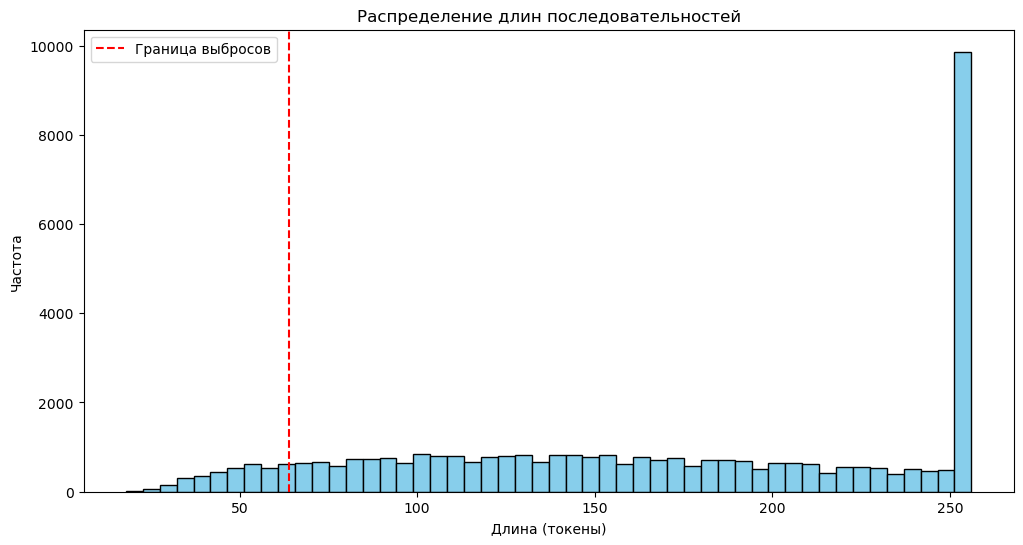

In [65]:
# Гистограмма
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=50, color='skyblue', edgecolor='black')
plt.axvline(x=64, color='red', linestyle='--', label='Граница выбросов')
plt.title('Распределение длин последовательностей')
plt.xlabel('Длина (токены)')
plt.ylabel('Частота')
plt.legend()
plt.show()

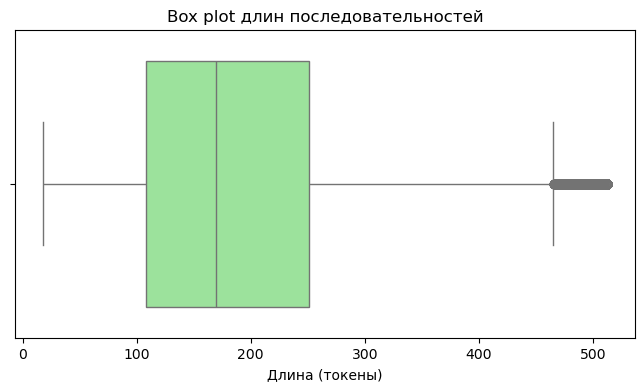

In [153]:
# Box plot
plt.figure(figsize=(8, 4))
sns.boxplot(x=lengths, color='lightgreen')
plt.title('Box plot длин последовательностей')
plt.xlabel('Длина (токены)')
plt.show()

In [ ]:
short_samples = [int(i) for i in np.where(np.array(lengths) < 10)[0]]  
print(f"Найдено {len(short_samples)} слишком коротких примеров (длина <10 токенов)")

# Просмотр случайных выбросов (с проверкой на пустой список)
if short_samples:
    for i in np.random.choice(short_samples, size=min(3, len(short_samples)), replace=False):
        sample = train_dataset[i]
        print(f"\nПример {i} (длина {len(sample['input_ids'])}):")
        print("Текст:", tokenizer.tokenizer.decode(sample['input_ids'], skip_special_tokens=True))
        print("Токены:", sample['input_ids'])
else:
    print("Короткие примеры не найдены")

## Обучение модели

In [35]:
training_args = TrainingArguments(
    output_dir='./full_train',
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,  
    num_train_epochs=5,
    fp16=False,
    bf16=True, 
    learning_rate=3e-5,
    optim="adamw_torch",
    save_strategy="steps", 
    save_steps=500,
    logging_steps=100,
    remove_unused_columns=False,  
)

In [39]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer.tokenizer,
    mlm_probability=0.15,
    pad_to_multiple_of=None,  
    mlm=True
)

In [41]:
class TqdmTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pbar = None
    
    def on_train_begin(self, args, state, control, **kwargs):
        self.pbar = tqdm(total=state.max_steps, desc="Обучение", dynamic_ncols=True)
        return super().on_train_begin(args, state, control, **kwargs)
    
    def on_step_end(self, args, state, control, **kwargs):
        if self.pbar is not None:
            self.pbar.update(1)
            self.pbar.set_postfix({
                'loss': f"{state.log_history[-1].get('loss', 0):.3f}",
                'lr': f"{state.log_history[-1].get('learning_rate', 0):.1e}",
                'GPU Mem': f"{torch.cuda.memory_allocated(0)/1024**3:.1f}GB"
            })
        return super().on_step_end(args, state, control, **kwargs)
    
    def on_train_end(self, args, state, control, **kwargs):
        if self.pbar is not None:
            self.pbar.close()
        return super().on_train_end(args, state, control, **kwargs)

In [43]:
#Добавляю callback для обработки NaN. С интервалом проверки 100
from transformers import TrainerCallback

class NanDetectorCallback(TrainerCallback):
    def __init__(self, check_interval=100):
        self.check_interval = check_interval
        
    def on_step_end(self, args, state, control, **kwargs):
        if state.global_step % self.check_interval == 0:
            for name, param in kwargs['model'].named_parameters():
                if param.grad is not None and (torch.isnan(param.grad).any() or torch.isinf(param.grad).any()):
                    print(f"NaN/Inf detected in {name} at step {state.global_step}")
                    # Автоматическое уменьшение lr
                    for g in kwargs['optimizer'].param_groups:
                        g['lr'] *= 0.8
                    break

In [45]:
trainer = TqdmTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[NanDetectorCallback()],  # Добавляем наш callback
)

In [43]:
# Проверка первых 3 примеров
for i in range(3):
    sample = train_dataset[i]
    print(f"\nПример {i}:")
    print("Длина:", len(sample['input_ids']))
    print("Токены:", sample['input_ids'][:10], "...", sample['input_ids'][-10:])

# Проверка коллатора
test_batch = data_collator([train_dataset[i] for i in range(4)])
print("\nТест коллатора:")
print({k: v.shape for k, v in test_batch.items()})


Пример 0:
Длина: 61
Токены: [2, 7081, 331, 2085, 866, 4674, 25698, 13778, 2215, 319] ... [16743, 700, 1129, 13678, 27266, 2085, 866, 548, 19634, 3]

Пример 1:
Длина: 105
Токены: [2, 14523, 329, 18252, 613, 16, 7081, 23101, 7578, 10141] ... [1887, 11226, 733, 17446, 865, 2277, 21288, 7089, 18, 3]

Пример 2:
Длина: 80
Токены: [2, 330, 3091, 15577, 7113, 30, 25698, 13778, 2215, 18397] ... [21, 320, 22, 4159, 2317, 14812, 11435, 809, 17315, 3]

Тест коллатора:
{'input_ids': torch.Size([4, 152]), 'attention_mask': torch.Size([4, 152]), 'labels': torch.Size([4, 152])}


In [47]:
print(f"Свободно памяти GPU: {torch.cuda.memory_allocated()/1024**3:.1f}/{torch.cuda.get_device_properties(0).total_memory/1024**3:.1f} GB")

Свободно памяти GPU: 0.1/8.0 GB


In [49]:
# Уточним распределение памяти
print(f"Занято: {torch.cuda.memory_allocated()/1024**3:.1f} GB")
print(f"Кэш: {torch.cuda.memory_reserved()/1024**3:.1f} GB")

Занято: 0.1 GB
Кэш: 0.2 GB


In [51]:
sample = data_collator([train_dataset[0]])
print("Маскированные токены:", tokenizer.tokenizer.convert_ids_to_tokens(sample["input_ids"][0]))

Маскированные токены: ['[CLS]', 'если', 'у', 'ва', '##с', 'есть', 'хор', '##ош', '##ие', 'з', '##нания', 'в', 'рек', '##лам', '##ных', 'интернет', '##те', '##х', '##нология', '##х', ',', 'по', '##нима', '##ние', '[MASK]', '##мар', '##кет', '##инг', '##а', '[MASK]', 'на', '[MASK]', '##ки', 'об', '##щения', 'с', 'в', '##ладе', '##ль', '##цами', 'бизнес', '##а', 'и', 'топ', '##мене', '##дж', '##ера', '##ми', ',', 'буде', '[MASK]', 'рад', '[MASK]', 'при', '##гла', '##сить', 'ва', '##с', 'на', '[MASK]', '[SEP]']


In [53]:
try:
    print(f"Память перед обучением: {torch.cuda.memory_allocated()/1024**3:.1f}/{torch.cuda.get_device_properties(0).total_memory/1024**3:.1f} GB")
    
    # Запуск обучения с мониторингом
    with tqdm(total=len(trainer.get_train_dataloader()), desc="Обучение") as pbar:
        trainer.train()
        pbar.update(len(trainer.get_train_dataloader()))
    
    print(f"Пиковое использование: {torch.cuda.max_memory_allocated()/1024**3:.1f} GB")
except RuntimeError as e:
    if "CUDA out of memory" in str(e):
        print("Не хватает памяти! Уменьшите batch_size до 8")
    raise

Память перед обучением: 0.1/8.0 GB


Обучение:   0%|          | 0/4940 [00:00<?, ?it/s]

{'loss': 8.2904, 'grad_norm': 2.152988910675049, 'learning_rate': 2.9519028340080973e-05, 'epoch': 0.08097165991902834}
{'loss': 6.5256, 'grad_norm': 2.3509018421173096, 'learning_rate': 2.90331983805668e-05, 'epoch': 0.16194331983805668}
{'loss': 5.8487, 'grad_norm': 2.3006386756896973, 'learning_rate': 2.8547368421052634e-05, 'epoch': 0.242914979757085}
{'loss': 5.4282, 'grad_norm': 2.687706708908081, 'learning_rate': 2.806153846153846e-05, 'epoch': 0.32388663967611336}
{'loss': 5.0636, 'grad_norm': 2.54367995262146, 'learning_rate': 2.7575708502024294e-05, 'epoch': 0.4048582995951417}
{'loss': 4.7822, 'grad_norm': 2.5486934185028076, 'learning_rate': 2.708987854251012e-05, 'epoch': 0.48582995951417}
{'loss': 4.5461, 'grad_norm': 2.510507822036743, 'learning_rate': 2.660404858299595e-05, 'epoch': 0.5668016194331984}
{'loss': 4.345, 'grad_norm': 2.7630391120910645, 'learning_rate': 2.6118218623481782e-05, 'epoch': 0.6477732793522267}
{'loss': 4.1645, 'grad_norm': 2.7493226528167725, '

Обучение: 100%|██████████| 4940/4940 [24:15<00:00,  3.39it/s]

{'train_runtime': 1454.8115, 'train_samples_per_second': 135.825, 'train_steps_per_second': 4.245, 'train_loss': 3.145651267356718, 'epoch': 5.0}
Пиковое использование: 1.7 GB


In [ ]:
# Очистка памяти после обучения
torch.cuda.empty_cache()

In [57]:
test_dataset = prepare_dataset(test_df, tokenizer)
test_results = trainer.evaluate(test_dataset)

Map:   0%|          | 0/4941 [00:00<?, ? examples/s]

{'eval_loss': 2.126847267150879, 'eval_runtime': 15.734, 'eval_samples_per_second': 314.034, 'eval_steps_per_second': 39.278, 'epoch': 5.0}


In [59]:
print(f"Test Perplexity: {np.exp(test_results['eval_loss']):.2f}")

Test Perplexity: 8.39


In [67]:
output_dir = "./mlm_results/final_model"
model.save_pretrained(output_dir)
tokenizer.tokenizer.save_pretrained(output_dir)
model.config.save_pretrained(output_dir)